# Time Domain Tutorial #3
## State Space Oscillators for real data

ASSC 2023

Emily Stephen

The `data` folder contains three files, each with 30 seconds of 
EEG data from a healthy subject during propofol‑induced unconsciousness:
-  `eeganes07laplac250_detrend_all_t180.mat` Awake, before propofol induction
-  `eeganes07laplac250_detrend_all_t3070.mat` Unconscious, at a low dose of propofol
-  `eeganes07laplac250_detrend_all_t4710.mat` Unconscious, at a high dose of propofol

Propofol anesthesia is characterized by two rhythms꞉ a global slow
wave (<1 Hz) and a frontal alpha rhythm (~10 Hz). In this tutorial:
1. we will use the iterative oscillator framework to discover the rhythms in one channel
2. using the fitted hidden state, we will explore the relationship between the instantaneous amplitude of the alpha and the instantaneous phase of the slow
3. finally, we will use the Common Oscillator Model to find the latent oscillators underlying all of the data, and we will compare the results to the Global coherence


In [1]:
import numpy as np
import os.path as op
import matplotlib.pyplot as plt
from scipy import io, signal
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity

# From mh105/somata
from somata.iterative_oscillator import IterativeOscillatorModel as IterOsc
from somata.iterative_oscillator.helper_functions import simulate_matsuda, sim_to_osc_object

## Load and plot the data

In [2]:
segment_names = ['t180','t3070','t4710']
filepaths = [f'../data/eeganes07laplac250_detrend_all_{tmin}.mat' for 
             tmin in segment_names]

datadicts = []
for name,f in zip(segment_names,filepaths):
    l = io.loadmat(f,squeeze_me=True)
    l['name'] = name
    datadicts.append(l)
    
Fs = datadicts[0]['Fs']
egrid_0indexed = datadicts[0]['egrid_0indexed']

In [3]:
def convert_grid(vec):
    # Input: 
    #    vec: (64,)
    # Returns:
    #    grid: (9,11) layout of the data in vec using egrid_0indexed
    grid = vec[egrid_0indexed.astype(int)]
    grid[np.isnan(egrid_0indexed)] = np.nan
    return grid

Text(0.5, 1.0, 'Electrode #41')

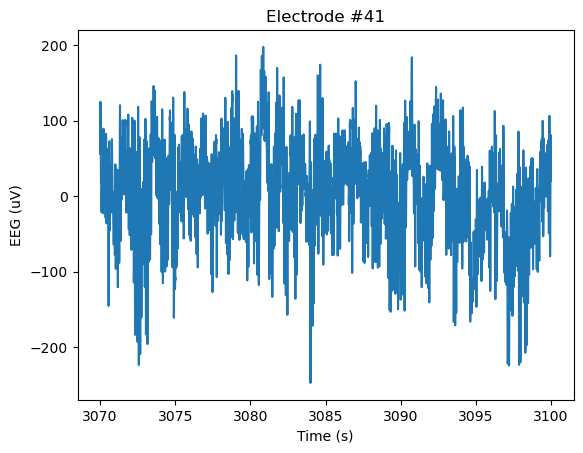

In [4]:
# Pick the low dose condition
y = datadicts[1]['y']
ta = datadicts[1]['ta']

# pick electrode 41
esel = 41

plt.figure()
plt.plot(ta,y[:,esel])
plt.xlabel('Time (s)')
plt.ylabel('EEG (uV)')
plt.title(f'Electrode #{esel}')

In [5]:
# Power spectrum
TW=5
ntapers = 8

m = Multitaper(y,
            sampling_frequency=Fs,
            time_halfbandwidth_product=TW,
            n_tapers=ntapers,
            start_time=ta[0])
c = Connectivity(fourier_coefficients=m.fft(),
            frequencies=m.frequencies,
            time=m.time)
S = c.power().squeeze()
fa = c.frequencies


Text(0.5, 1.0, 'Electrode #41')

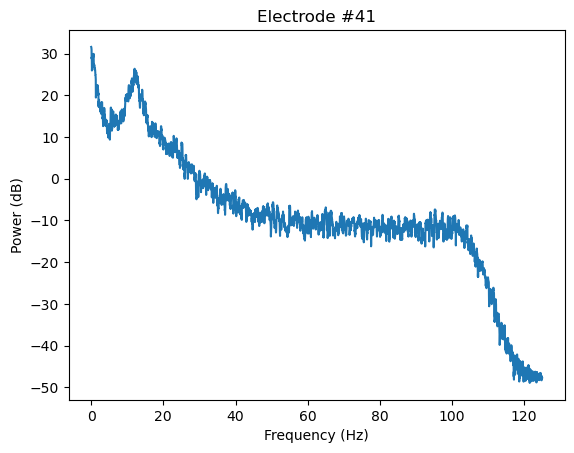

In [6]:
plt.figure()
plt.plot(fa,10*np.log10(S[:,esel]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title(f'Electrode #{esel}')

## 1. Use the analytic signal to estimate PAC between slow and alpha on electrode 41

1. Bandpass filter the signal on electrode 41 in slow (<1 Hz) and alpha (8-12 Hz) bands
2. Compute the analytic phase of the slow and the analytic amplitude of the alpha
3. Plot the slow and alpha analytic signals (1) as a timeseries, and (2) as a phasor
4. Plot the instantaneous phase of the slow and the instantaneous amplitude of the alpha
5. Plot a bar plot of the mean instantaneous amplitude of the alpha as a function of the instantaneous phase of the slow


In [7]:
slow_lp = 1
alpha_band = [8,12]

# Filter in the bands 
b, a = signal.butter(4, alpha_band, btype='bandpass', fs=Fs)
fh_hz, h = signal.freqz(b, a, fs=Fs)
y_alpha = signal.filtfilt(b, a, y[:,esel])

b, a = signal.butter(4, slow_lp, btype='lowpass', fs=Fs)
fh_hz, h = signal.freqz(b, a, fs=Fs)
y_slow = signal.filtfilt(b, a, y[:,esel])


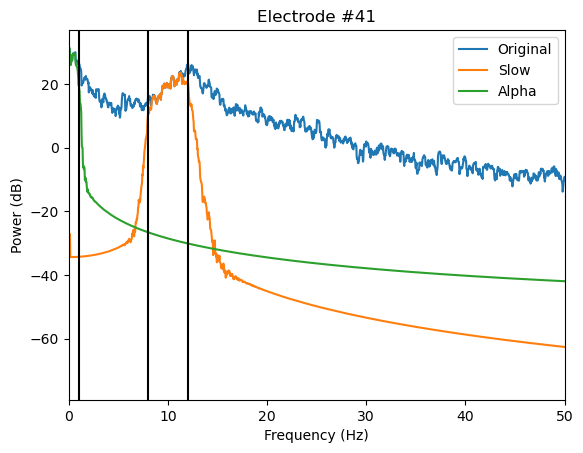

In [8]:
m = Multitaper(np.vstack([y_alpha,y_slow]).T,
            sampling_frequency=Fs,
            time_halfbandwidth_product=TW,
            n_tapers=ntapers,
            start_time=ta[0])
c = Connectivity(fourier_coefficients=m.fft(),
            frequencies=m.frequencies,
            time=m.time)
S_filt = c.power().squeeze()

plt.figure()
plt.plot(fa,10*np.log10(S[:,esel]))
plt.plot(fa,10*np.log10(S_filt))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title(f'Electrode #{esel}')
plt.axvline(slow_lp,color='k')
plt.axvline(alpha_band[0],color='k')
plt.axvline(alpha_band[1],color='k')
plt.xlim([0,50])
plt.legend(['Original','Slow','Alpha'])

In [9]:
# Compute analytic phase of slow and analytic amplitude of alpha
slow_as = signal.hilbert(y_slow)
alpha_as = signal.hilbert(y_alpha)
slow_phase_as = np.angle(slow_as)
alpha_amp_as = np.abs(alpha_as)


Text(0.5, 1.0, 'Alpha Analytic Signal')

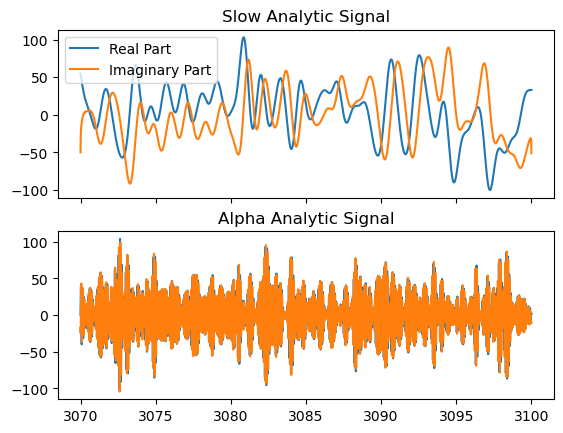

In [10]:
# Plot as timeseries

[fig,axs] = plt.subplots(2,1,sharex=True)
for i,analytic_sig in enumerate([slow_as,alpha_as]):
    axs[i].plot(ta,np.real(analytic_sig),label='Real Part')
    axs[i].plot(ta,np.imag(analytic_sig),label='Imaginary Part')
axs[0].legend()
axs[0].set_title('Slow Analytic Signal')
axs[1].set_title('Alpha Analytic Signal')

Text(0.5, 1.0, 'Alpha Phasor')

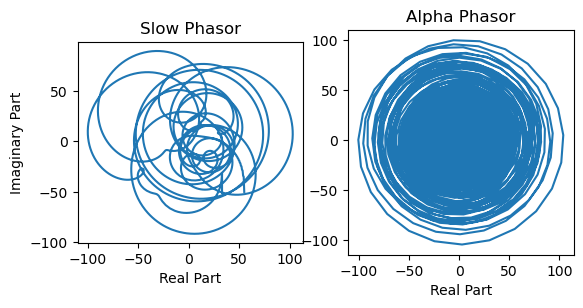

In [11]:
# Plot as phasor
[fig,axs] = plt.subplots(1,2)
for i,analytic_sig in enumerate([slow_as,alpha_as]):
    axs[i].plot(np.real(analytic_sig),np.imag(analytic_sig))
    axs[i].set_aspect('equal')
    axs[i].set_xlabel('Real Part')
axs[0].set_ylabel('Imaginary Part')
axs[0].set_title('Slow Phasor')
axs[1].set_title('Alpha Phasor')

Text(0.5, 0, 'Time (s)')

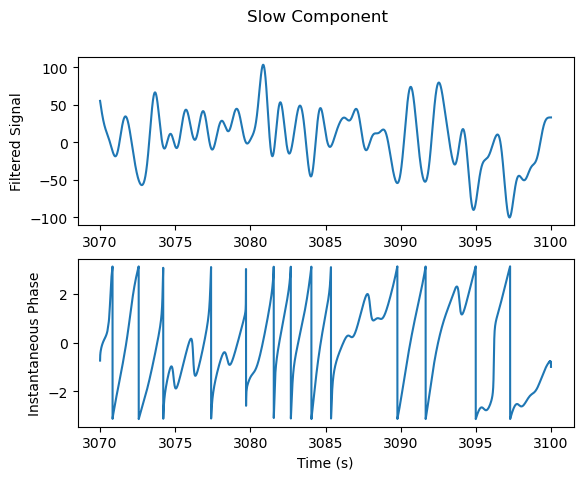

In [12]:
# Plot the instantaneous phase of the slow

[fig,axs] = plt.subplots(2,1)
fig.suptitle('Slow Component')
axs[0].plot(ta,y_slow)
axs[0].set_ylabel('Filtered Signal')
axs[1].plot(ta,slow_phase_as)
axs[1].set_ylabel('Instantaneous Phase')
axs[1].set_xlabel('Time (s)')


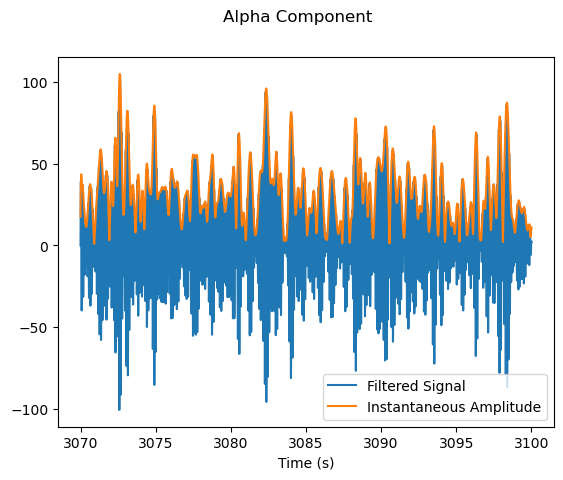

In [13]:
# Plot the instantaneous amplitude of the alpha
fig = plt.figure()
fig.suptitle('Alpha Component')
plt.plot(ta,y_alpha,label='Filtered Signal')
plt.plot(ta,alpha_amp_as,label='Instantaneous Amplitude')
plt.xlabel('Time (s)')
plt.legend()

Text(0, 0.5, 'Alpha amplitude')

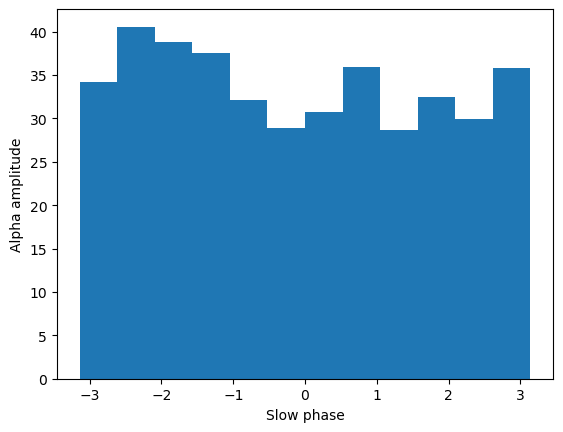

In [14]:
# Plot a bar plot of the mean alpha amplitude vs slow phase

nbins=12
amp_by_phase_as = np.zeros(nbins)
phase_bin_edges = np.linspace(-np.pi,np.pi,nbins+1,endpoint=True)
for i,(binstart,binend) in enumerate(zip(phase_bin_edges[:-1],phase_bin_edges[1:])):
    amp_by_phase_as[i] = np.mean(alpha_amp_as[np.logical_and(slow_phase_as>=binstart,slow_phase_as<binend)])
    
phase_bin_centers = (phase_bin_edges[:-1]+phase_bin_edges[1:])/2
phase_bin_width = phase_bin_edges[1]-phase_bin_edges[0]
plt.figure()
plt.bar(phase_bin_centers,amp_by_phase_as,width=phase_bin_width)
plt.xlabel('Slow phase')
plt.ylabel('Alpha amplitude')

## 2. Use somata to decompose electrode 41 into its component frequencies

1. Based on the power spectrum, choose the frequency above which there should only be white noise. Use this value as the `noise_start` parameter 
2. Instantiate the Iterative Oscillator object for electrode 41
3. Run the fit (iterate)
4. Plot the likelihood and selected model
5. Plot the results in the time and frequency domain

In [15]:
# Choose the frequency above which there should only be white noise
noise_start = 30

# Initialize Iterative Oscillator object
io_orig = IterOsc(y[:,esel], Fs, noise_start, verbose=False)  

# Run through iterations to fit model
io_orig.iterate(osc_range=7, plot_innov=False, verbose=False)

Text(0.5, 1.0, 'Log Likelihood')

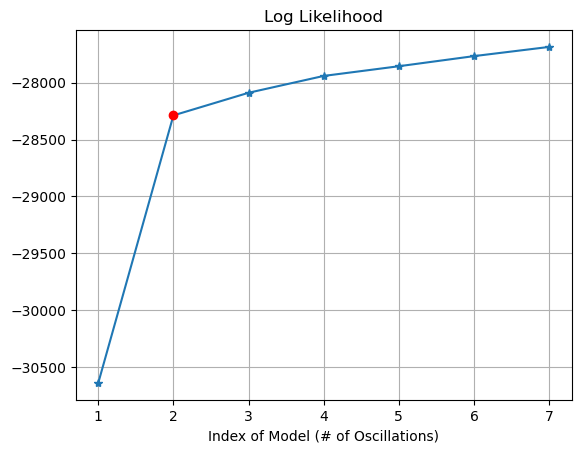

In [16]:
# Plot likelihood and selected model (may not be the highest likelihood)
plt.figure()
plt.plot(range(1, len(io_orig.fitted_osc) + 1), io_orig.ll, '-*', label='__nolegend__')
plt.scatter(io_orig.knee_index + 1, io_orig.ll[io_orig.knee_index], color='red', zorder=2,
            label='model selected with knee')
plt.xlabel('Index of Model (# of Oscillations)')
plt.grid('on')
plt.title('Log Likelihood')

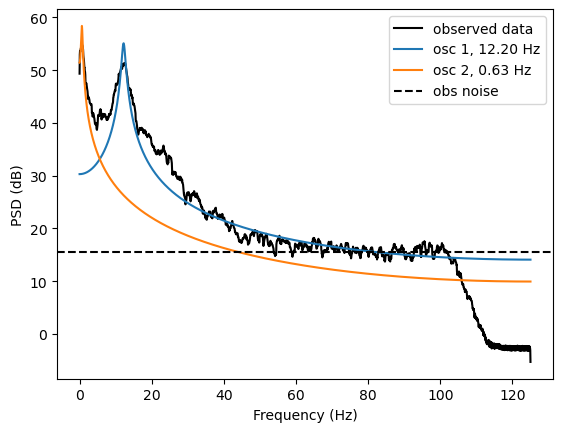

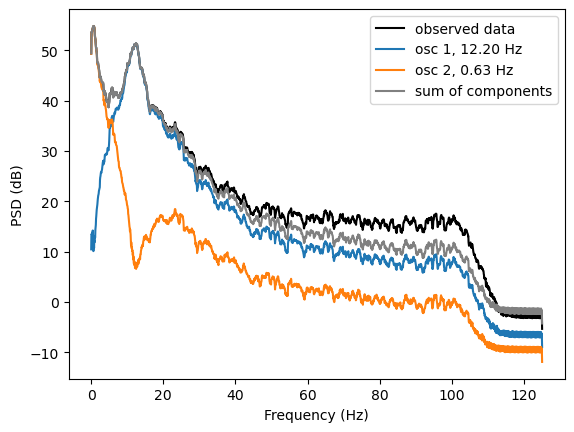

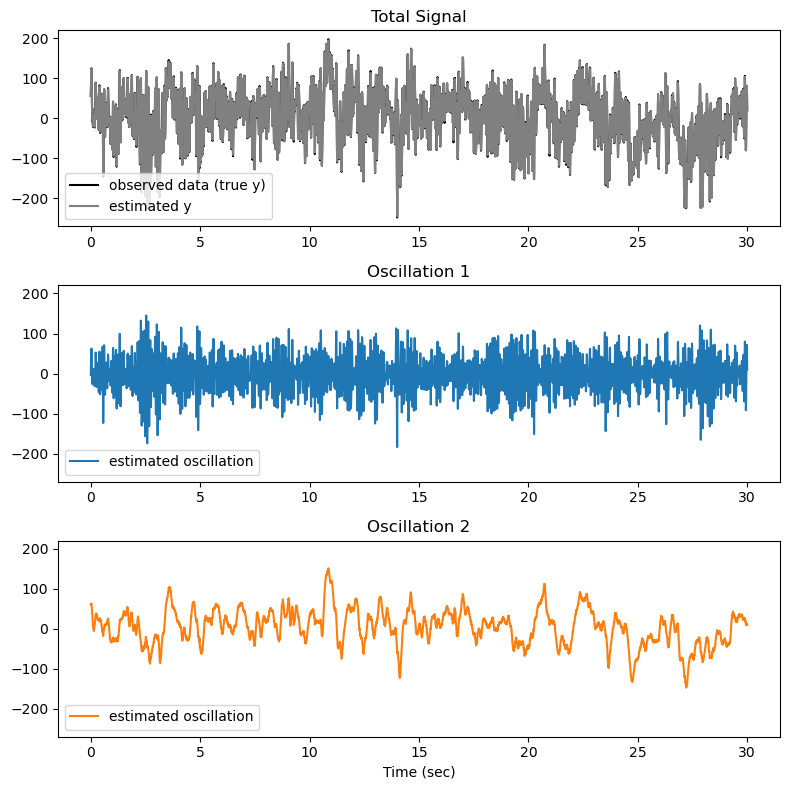

In [17]:
# Plot frequency domain (from parameters and from estimated x_t)

best_fit_osc = io_orig.fitted_osc[io_orig.knee_index]

for version in ['theoretical', 'actual']:
    _ = best_fit_osc.visualize_freq(version, y=y[:,esel])
    
# Plot time domain estimated x_t
_ = best_fit_osc.visualize_time(y=y[:,esel])

In [18]:
print(best_fit_osc)

 nstate   = 4     ncomp    = 2
 nchannel = 1     ntime    = 7500
 nmodel   = 1
 components = [Osc(0)<fd60>, Osc(0)<fd90>]
 F  .shape = (4, 4)     Q  .shape = (4, 4)
 mu0.shape = (4, 1)     Q0 .shape = (4, 4)
 G  .shape = (1, 4)     R  .shape = (1, 1)
 y  .shape = None       Fs = 250.0 Hz
 damping a = [0.988 0.995]
 freq Hz   = [12.2   0.63]
 sigma2    = [49.305 19.542]
 obs noise R = [[17.699]]
 dc index  = None



## 3. Phase Amplitude Coupling

1. Plot the slow and alpha hidden states from the fitted SSO model (1) as a timeseries, and (2) as a phasor
2. Plot the instantaneous phase of the slow and the instantaneous amplitude of the alpha, using the following equations:
\begin{equation*}
    \text{amplitude(t)} = \sqrt{(x_{\text{Re}}(t))^2 + (x_{\text{Im}}(t))^2}\\
    \text{phase(t)} = \text{atan2}(x_{\text{Im}}(t),x_{\text{Re}}(t))
\end{equation*}

3. Plot a bar plot of the mean instantaneous amplitude of the alpha as a function of the instantaneous phase of the slow


Bonus ideas:
- Compare the high dose PAC to the low dose PAC. Why would they be called "peak max" and "trough max"? Which one is which?
- Implement the regression framework described here: Soulat, H., Stephen, E. P., Beck, A. M., & Purdon, P. L. (2022). State space methods for phase amplitude coupling analysis. Scientific Reports, 12(1), 15940. [10.1038/s41598-022-18475-3](https://doi.org/10.1038/s41598-022-18475-3)


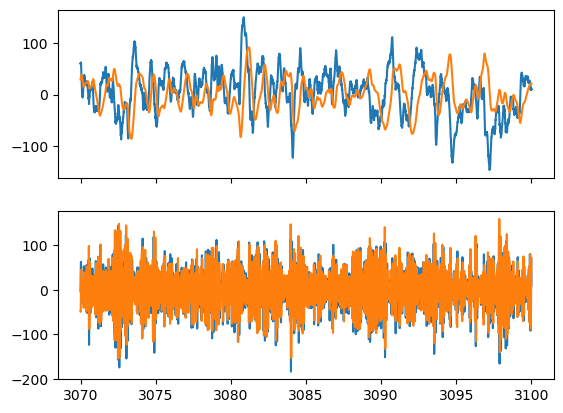

In [19]:
# Identify the slow and alpha states
slow_i = np.argmin(np.abs(best_fit_osc.freq-slow_lp))
alpha_i = np.argmin(np.abs(best_fit_osc.freq-np.mean(alpha_band)))
                    
# Plot the full hidden states
kalman_out = best_fit_osc.kalman_filt_smooth(y=y[:,[esel]].T,return_dict=True)
x_slow = kalman_out['x_t_n'][2*slow_i:2*slow_i+2, 1:] # drop the first time index
x_alpha = kalman_out['x_t_n'][2*alpha_i:2*alpha_i+2, 1:] # drop the first time index

[fig,axs] = plt.subplots(best_fit_osc.ncomp,1,sharex=True)
axs[0].plot(ta,x_slow.T)
axs[1].plot(ta,x_alpha.T)

Text(0.5, 1.0, 'Alpha Phasor')

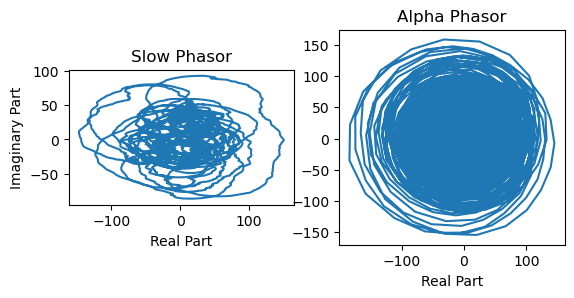

In [20]:
[fig,axs] = plt.subplots(1,best_fit_osc.ncomp)
axs[0].plot(x_slow[0,:],x_slow[1,:])
axs[0].set_aspect('equal')
axs[0].set_xlabel('Real Part')
axs[0].set_ylabel('Imaginary Part')
axs[0].set_title('Slow Phasor')
axs[1].plot(x_alpha[0,:],x_alpha[1,:])
axs[1].set_aspect('equal')
axs[1].set_xlabel('Real Part')
axs[1].set_title('Alpha Phasor')

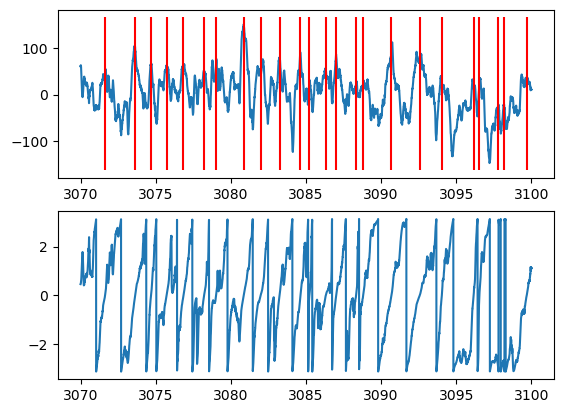

In [21]:
# Extract the instantaneous phase of the slow oscillation
from math import atan2

slow_phase = np.array([atan2(x_slow[1,i],x_slow[0,i]) for i in range(len(ta))])

[fig,axs] = plt.subplots(2,1)
axs[0].plot(ta,x_slow[0,:])
axs[1].plot(ta,slow_phase)
axs[0].vlines(ta[np.argwhere(np.diff(np.sign(slow_phase))==2)],
              axs[0].get_ylim()[0],
              axs[0].get_ylim()[1],
             color='r')

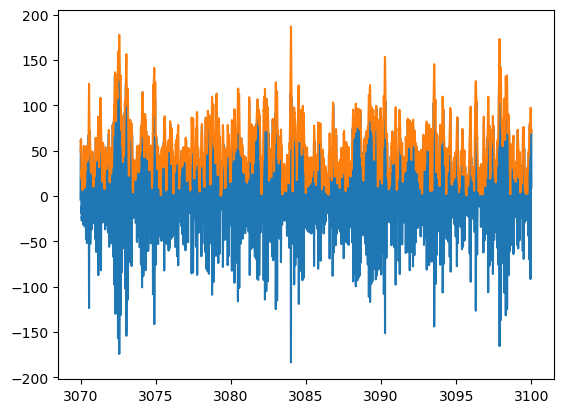

In [22]:
# Extract the instantaneous amplitude of the alpha oscillation

alpha_amplitude = np.sqrt(x_alpha[0,:]**2 + x_alpha[1,:]**2)

plt.figure()
plt.plot(ta,x_alpha[0,:])
plt.plot(ta,alpha_amplitude)

Text(0, 0.5, 'Alpha amplitude')

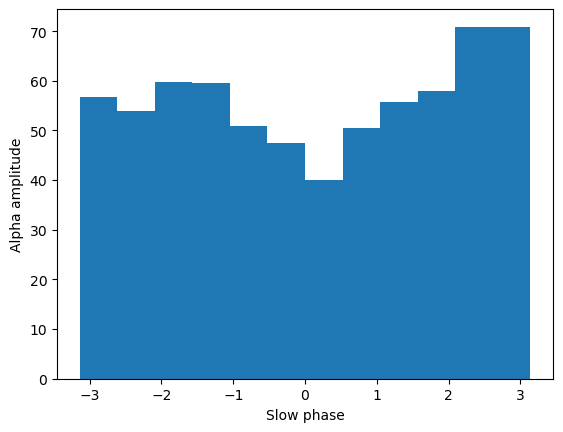

In [23]:
# Plot a bar plot of the mean alpha amplitude vs slow phase

amp_by_phase_sso = np.zeros(nbins)
for i,(binstart,binend) in enumerate(zip(phase_bin_edges[:-1],phase_bin_edges[1:])):
    amp_by_phase_sso[i] = np.mean(alpha_amplitude[np.logical_and(slow_phase>=binstart,slow_phase<binend)])
    
plt.figure()
plt.bar(phase_bin_centers,amp_by_phase_sso,width=phase_bin_width)
plt.xlabel('Slow phase')
plt.ylabel('Alpha amplitude')
    

### 4. Compare analytic signal to the SSO method

1. Compare the filtered slow and alpha signals to the slow and alpha hidden states from the SSO model
2. Compare the PAC computed with the analytic signal to the SSO method

(3070.0, 3075.0)

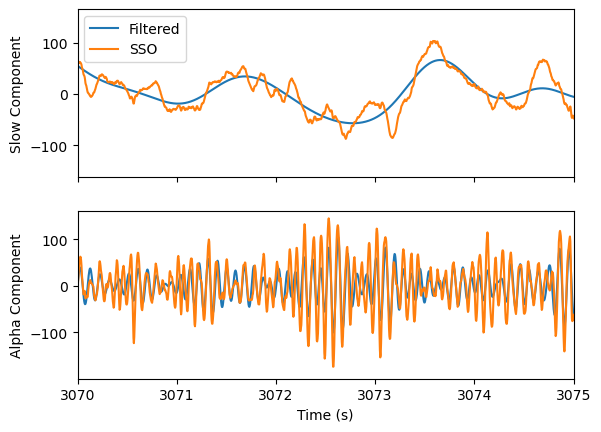

In [24]:
# Compare slow and alpha components

[fig,axs] = plt.subplots(2,1,sharex=True)
axs[0].plot(ta,y_slow,label='Filtered')
axs[0].plot(ta,x_slow[0,:],label='SSO')
axs[0].set_ylabel('Slow Component')
axs[0].legend()
axs[1].plot(ta,y_alpha,label='Filtered')
axs[1].plot(ta,x_alpha[0,:],label='SSO')
axs[1].set_ylabel('Alpha Component')
axs[1].set_xlabel('Time (s)')
axs[1].set_xlim([3070,3075])


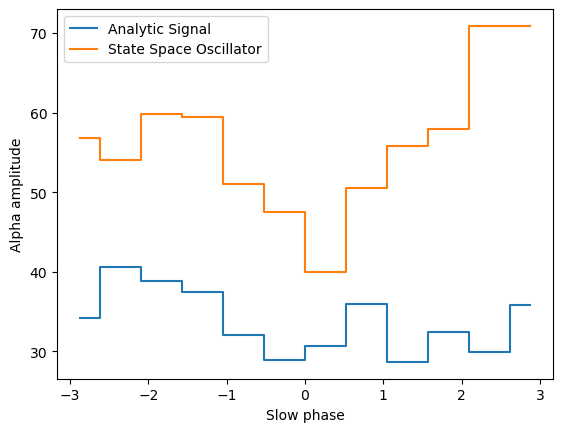

In [25]:
# Compare PAC
plt.figure()
plt.step(phase_bin_centers,amp_by_phase_as,where='mid',label='Analytic Signal')
plt.step(phase_bin_centers,amp_by_phase_sso,where='mid',label='State Space Oscillator')
plt.xlabel('Slow phase')
plt.ylabel('Alpha amplitude')
plt.legend()